# NetLSD experiments

## Imports

In [1]:
import netlsd as net
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from glob import glob

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, KMeans

In [2]:
sys.path.extend(['./..'])  # have to add the project path manually to the Python path
os.chdir('./..')

In [3]:
from src.utils import load_pickle
from src.Tree import TreeNode

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = (10, 7)

In [6]:
def get_graph_vec(g: nx.Graph, kernel: str='heat', dim: int=250, eigenvalues: int=20) -> np.ndarray:
    eigenvalues = min(g.order(), 20)
    return net.netlsd(g, kernel=kernel, timescales=np.logspace(-2, 2, dim), eigenvalues=eigenvalues)

In [7]:
def compare_graphs(g1: nx.Graph, g2: nx.Graph, kernel: str='heat', dim: int=250, eigenvalues: int=20) -> float:
    g_vec1 = get_graph_vec(g=g1, kernel=kernel, dim=dim, eigenvalues=eigenvalues)
    g_vec2 = get_graph_vec(g=g2, kernel=kernel, dim=dim, eigenvalues=eigenvalues)
    return net.compare(g_vec1, g_vec2)

In [8]:
def graph_distance(vec1: np.array, vec2: np.array):
    return net.compare(vec1, vec2)

In [9]:
def make_df(graphs, kind):
    cols = ['name', 'kind', 'n', 'm']
    cols.extend([f'v{i}' for i in range(250)])
    
    rows = {col: [] for col in cols}
    for g in graphs:
        print(f'{g.name}', end='\t', flush=True)
        rows['name'].append(g.name)
        rows['kind'] = kind
        rows['n'].append(g.order())
        rows['m'].append(g.size())
        g_vec = get_graph_vec(g)
        for i, val in enumerate(g_vec):
            rows[f'v{i}'].append(val)

    df = pd.DataFrame(rows)
    return df

In [30]:
def calculate_pca_tsne(df):
    print('Computing PCA and tSNE')
    vectors = [col for col in df.columns.to_list() if col.startswith('v')]
    df['pca_x'] = [0]*df.shape[0]; df['pca_y'] = [0]*df.shape[0]
    df['tsne_x'] = [0]*df.shape[0]; df['tsne_y'] = [0]*df.shape[0]

    df[['pca_x', 'pca_y']] = pca_2.fit_transform(df.loc[:, vectors])
    df[['tsne_x', 'tsne_y']] = tsne_2.fit_transform(df.loc[:, vectors])

    df['pca_1'] = pca_1.fit_transform(df.loc[:, vectors])
    df['tsne_1'] = tsne_1.fit_transform(df.loc[:, vectors])
    print('PCA and tSNE done')
    return df

In [11]:
def get_graphs(ns, kind):
    graphs = []
    print(f'Generating {len(ns)} {kind} graphs')
    if kind == 'ring_cliq':
        for n in ns:
            n = n // 4
            g = nx.ring_of_cliques(n, 4)
            g.name = f'ring-cliq-{n}-4'
            graphs.append(g)
            
    elif kind == 'ring':
        for n in ns:
            g = nx.cycle_graph(n)
            g.name = f'ring-{n}'
            graphs.append(g)
    
    elif kind == 'cliq':
        for n in ns:
            g = nx.complete_graph(n)
            g.name = f'cliq-{n}'
            graphs.append(g)
    return graphs

In [12]:
tsne_2 = TSNE(n_components=2, n_jobs=4, verbose=20, init='pca')
pca_2 = PCA(n_components=2)

tsne_1 = TSNE(n_components=1, n_jobs=4, verbose=20, init='pca')
pca_1 = PCA(n_components=1)

## Generate graphs

### Start with ring of cliques 
#### Different sizes (n=10, 20, ..., 10000)

In [13]:
ns = [50, 100, 200, 500, 750, 1_000, 1_500, 2_000]# , 3_000, 5_000] #, 7_500, 10_000]

rings = get_graphs(ns=ns, kind='ring')
cliqs = get_graphs(ns=ns, kind='cliq')
ring_cliqs = get_graphs(ns=ns, kind='ring')

Generating 8 ring graphs
Generating 8 cliq graphs
Generating 8 ring graphs


In [14]:
ring_cliq_df = make_df(ring_cliqs, kind='ring_cliq')
ring_df = make_df(rings, kind='ring')
cliq_df = make_df(cliqs, kind='cliq')

ring-50	ring-100	ring-200	ring-500	ring-750	ring-1000	ring-1500	ring-2000	ring-50	ring-100	ring-200	ring-500	ring-750	ring-1000	ring-1500	ring-2000	cliq-50	cliq-100	cliq-200	cliq-500	cliq-750	cliq-1000	cliq-1500	cliq-2000	

In [15]:
diff_topo_df = pd.concat([ring_cliq_df, ring_df, cliq_df])

In [17]:
diff_topo_df.to_csv(f'./analysis/csv/topo-ring-cliq.csv', index=False)

### do some high dimensional clustering - OPTICS and k-means to see if netLSD is able to distinguish the three classes of graphs

In [18]:
kmeans = KMeans(n_clusters=3)
optics = OPTICS(min_samples=2)

In [27]:
vectors = [col for col in diff_topo_df.columns.to_list() if col.startswith('v')]

diff_topo_df['kmeans'] = kmeans.fit(diff_topo_df.loc[:, vectors]).labels_
diff_topo_df['optics'] = optics.fit(diff_topo_df.loc[:, vectors]).labels_

### Plotting the PCA/t-SNE for ring cliques of different sizes

In [32]:
diff_topo_df = calculate_pca_tsne(diff_topo_df)

Computing PCA and tSNE
[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.015s
[t-SNE] Iteration 50: error = 62.8915329, gradient norm = 0.0444589 (50 iterations in 0.102s)
[t-SNE] Iteration 100: error = 47.5803757, gradient norm = 0.1157494 (50 iterations in 0.080s)
[t-SNE] Iteration 150: error = 55.0414505, gradient norm = 0.3149315 (50 iterations in 0.071s)
[t-SNE] Iteration 200: error = 46.4201355, gradient norm = 0.5327443 (50 iterations in 0.048s)
[t-SNE] Iteration 250: error = 43.7593994, gradient norm = 0.4448741 (50 iterations in 0.054s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.759399
[t-SNE] Iteration 300: error = 0.0843315, gradient norm = 0.0008329 (50 iterations in 0.067s)
[t-SNE] Iteration 350: error = 0.01

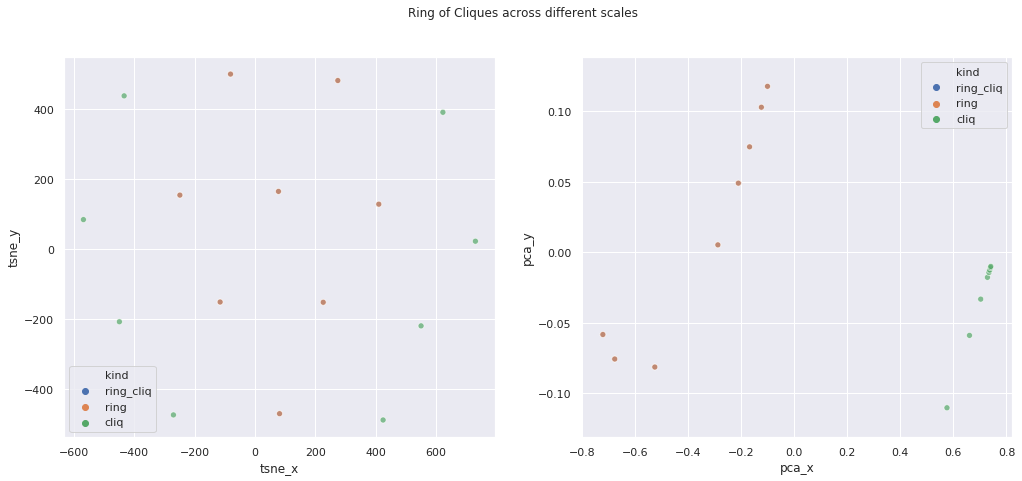

In [45]:
fig, (ax0, ax1) = plt.subplots(1 ,2, figsize=(17, 7))
sns.scatterplot(x='tsne_x', y='tsne_y', data=diff_topo_df, hue='kind', sizes=(100, 100), alpha=0.7, ax=ax0);
sns.scatterplot(x='pca_x', y='pca_y', data=diff_topo_df, hue='kind', sizes=(100, 100), alpha=0.7, ax=ax1);
plt.suptitle('Ring of Cliques across different scales');

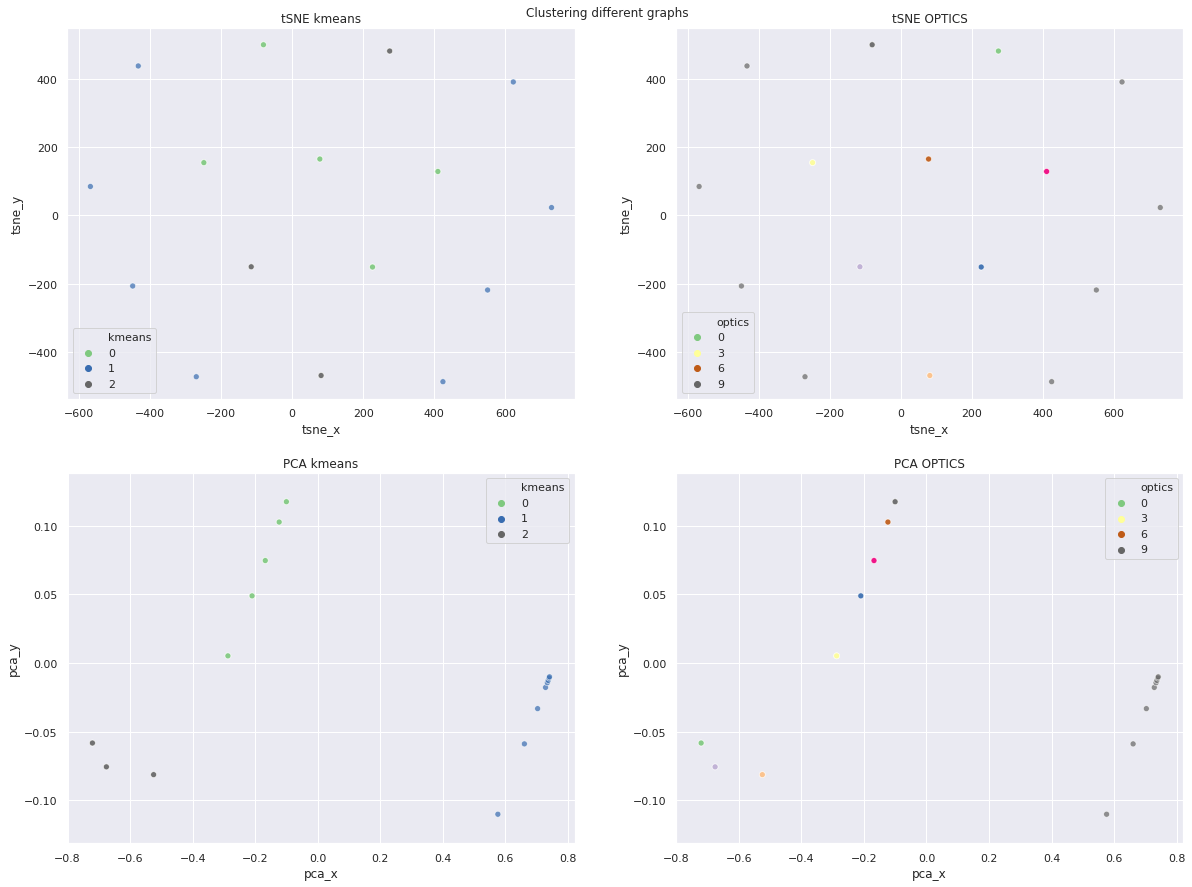

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

sns.scatterplot(x='tsne_x', y='tsne_y', data=diff_topo_df, hue='kmeans', sizes=(100, 100), alpha=0.7, palette='Accent', ax=axes[0, 0]);
axes[0, 0].set_title('tSNE kmeans');

sns.scatterplot(x='tsne_x', y='tsne_y', data=diff_topo_df, hue='optics', sizes=(100, 100), alpha=0.7, palette='Accent', ax=axes[0, 1]);
axes[0, 1].set_title('tSNE OPTICS');

sns.scatterplot(x='pca_x', y='pca_y', data=diff_topo_df, hue='kmeans', sizes=(100, 100), alpha=0.7, palette='Accent', ax=axes[1, 0]);
axes[1, 0].set_title('PCA kmeans');

sns.scatterplot(x='pca_x', y='pca_y', data=diff_topo_df, hue='optics', sizes=(100, 100), alpha=0.7, palette='Accent', ax=axes[1, 1]);
axes[1, 1].set_title('PCA OPTICS');

plt.suptitle('Clustering different graphs', y=0.9);